In [87]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
from tqdm import tqdm
import matplotlib as mpl
import time

def Lorentzian(eex, ee, gam):
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

In [88]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 6,3.6
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams.update({'figure.autolayout': True})

In [142]:
def tophat(emax = 3, N = 16, samples = 300):
    eex = np.linspace(-6,6,samples)
    evs = np.linspace(-emax,emax,N)
    
    target = np.zeros(len(eex))
    for ev in evs:
        target += (1/N)*Lorentzian(eex, ev, gam = 0.1)
        
    principal_target = 1/(2*emax)*np.array([1 if abs(ee)<emax else 0 for ee in eex])
    return (eex, target, principal_target)

             
def doublehat(emax = 4, emin = 1, N = 16, samples = 300):
    eex = np.linspace(-6,6,samples)
    evs = np.linspace(emin,emax,N//2)
    evs = np.sort(np.hstack((-evs,evs)))
    
    target = np.zeros(len(eex))
    for ev in evs:
        target += (1/N)*Lorentzian(eex, ev, gam = 0.1)
        
    principal_target = 1/(2*(emax-emin))*np.array([1 if (abs(ee)<emax and abs(ee)>emin) else 0 for ee in eex])
    return (eex, target, principal_target)

def asymmetrichat(e0 = -3, e1 = 0, e2 = 1, e3 = 2, N = 16, samples = 300):
    eex = np.linspace(-6,6,samples)
    
    bandwidth = (e1-e0)+e3-e2
    evsL = np.linspace(e0,e1,int((e1-e0)/bandwidth *N))
    evsR = np.linspace(e2,e3,int((e3-e2)/bandwidth *N))
    evs = np.sort(np.hstack((evsL,evsR)))
    
    target = np.zeros(len(eex))
    for ev in evs:
        target += (1/N)*Lorentzian(eex, ev, gam = 0.1)
        
    principal_target = 1/(2*(emax-emin))*np.array([1 if (abs(ee)<emax and abs(ee)>emin) else 0 for ee in eex])
    return (eex, target, principal_target)

In [143]:
class Model:
    """
    The Model class defines the problem. It specifies the size of the grid, the number of atoms, 
    the decay power of the hopping function and the target DOS to be approximated.
    """
    
    def __init__(self, N = 50, L =15, W = 15, alpha = 3, res = 0.1, target=tophat()):
        self.t = 1 
        self.N = N # Number of atoms
        self.L = L # LxW square grid of sites available to bee occupied by atoms 
        self.W = W
        self.alpha = alpha #Hopping between site i and j goes as 1/dist(i,j)^alpha where dist is the Euclidean distance
        self.eex, self.target, self.principal_target = target
        if self.principal_target.any == None:
            self.principal_target = self.target
        self.de = self.eex[1]-self.eex[0]
        self.res = res
        
        
        self.sites = [(x,y) for y in range(int(self.W//self.res)) for x in range(int(self.L//self.res))] # List of all available sites
        self.setup = {"t" : self.t, "alpha" : self.alpha, "eex" : self.eex, "res": res} # Parameters to pass to configuration class
        
        inds =  np.random.choice(np.arange(len(self.sites)), self.N, replace = False) # Initially occupied N sites chosen randomly
        self.occupied_sites = [self.sites[ind] for ind in inds]
        self.init_config = configuration(self.occupied_sites, setup = self.setup)   

    def optimize(self, runtime = 10, search_radius = 3, include_site = True):
        """
        A stochastic steepest descent alogrithm to get as close as possible to the the target DOS
        """
        def choose_site(): # Choose an occupied site at random
            ind =  np.random.choice(np.arange(len(self.occupied_sites)))
            return self.occupied_sites[ind]
        
        def find_empty_neighbours(site, search_radius, include_site = True): # Find all vacant neighbouring sites (up to 3 spaces away) to a given site
            p,q = site
            options = [(p+dp, q+dq) for dp in range(-search_radius, search_radius) for dq in range(-search_radius, search_radius)]
            options = [option for option in options if option in self.sites and option not in self.occupied_sites]
            if include_site:
                options.append(site)

            return options
        
        def calculate_error(config):
            DOS = config.get_DOS()
            return self.de*np.linalg.norm(DOS - self.target)
        
        def find_best_move(site, options): #
            errs = []
            for option in options: # Get a list of potential new sites for site
                new_sites = list(self.occupied_sites)
                new_sites.remove(site)
                new_sites.append(option)
                
                new_config = configuration(new_sites, setup = self.setup)
                errs.append(calculate_error(new_config)) # Calculate the residual from each move
                
            new_site = options[errs.index(min(errs))]
            self.occupied_sites.remove(site) # Pick the new location with lowest error
            self.occupied_sites.append(new_site)
            return min(errs)
        
        initial_error = calculate_error(configuration(self.occupied_sites, setup = self.setup))
        err_log = [initial_error] # Logs residual error over the runtime
        for _ in range(runtime): 
            options = []
            while options == []: 
                site = choose_site() # pick a random site
                options = find_empty_neighbours(site, search_radius = search_radius, include_site = include_site) # Find available spaces around it

            err_log.append(find_best_move(site, options)) # Pick the available space with the lowest error
            
        return err_log
        
class configuration:
    """
    This class takes a particular set of occupied sites. The methods allow the construction of matrix Hamiltonians
    corresponding to it and the calculation of the Density of states.
    """
    def __init__(self, occupied_sites, setup = {}):
        self.occupied_sites = occupied_sites
        self.N = len(self.occupied_sites)
        
        self.t = setup["t"]
        self.alpha = setup["alpha"]
        self.eex = setup["eex"]
        self.res = setup["res"]
        
        self.make_system()
        
    def hopping(self, site1, site2):
        d = np.linalg.norm(site1.pos-site2.pos)
        return -self.t*d**(-self.alpha)
        
    def make_system(self):
        lat = kwant.lattice.square(a = self.res)
        syst = kwant.Builder()
        
        syst[(lat(*index) for index in self.occupied_sites)] = 0 * self.t
        syst[((lat(*index1), lat(*index2)) for index2 in self.occupied_sites for index1 in self.occupied_sites if index1 != index2)] = self.hopping
        self.syst = syst
        return self.syst
    
    def get_DOS(self, gam = 0.1):
        fsyst = self.syst.finalized()
        H = fsyst.hamiltonian_submatrix()
        evs, evecs = np.linalg.eig(H)
        self.DOS = [0]*len(self.eex)
        for ee in evs:
            self.DOS += (1/self.N)*Lorentzian(self.eex,ee,gam)
        return self.DOS
    
    def get_dimers(self):
        unpaired_points = self.occupied_sites
        
        while len(unpaired_points)>1:
            np.random.choice

## testing various search radii

In [145]:
eex = np.linspace(-6,6,100)
target = asymmetrichat()

In [146]:
# radii = [1,2,3,4,5,6]
radii = [3]
tests = []
err_logs = []
times = []
for radius in tqdm(radii):
    np.random.seed(0)
    test = Model(N = 16, L =16, W = 16, alpha = 3, res = 0.2, target = target) 
    np.random.seed(None)
    start = time.time()
    err_log = test.optimize(100, search_radius = radius)
    stop = time.time()
    times.append(stop - start)
    err_logs.append(err_log)
    tests.append(test) 

100%|██████████| 1/1 [00:20<00:00, 20.61s/it]


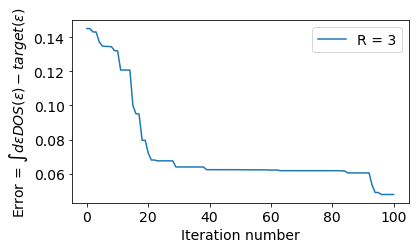

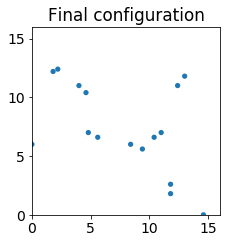

In [147]:
fig, ax = plt.subplots()
[ax.plot(err_logs[i], label = "R = {}".format(radii[i])) for i in range(len(tests))]
ax.set_ylabel("Error = $\\int d\\epsilon DOS(\\epsilon) - target(\\epsilon)$")
ax.set_xlabel("Iteration number")
ax.legend()

for test in tests:
    fig, ax = plt.subplots()
    kwant.plot(configuration(test.occupied_sites, setup = test.setup).syst, hop_color = 'white', ax = ax, site_size = 0.5)
    ax.set_aspect('equal')
    ax.set_xlim((0,test.L))
    ax.set_ylim((0,test.W))
    ax.set_title("Final configuration")
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


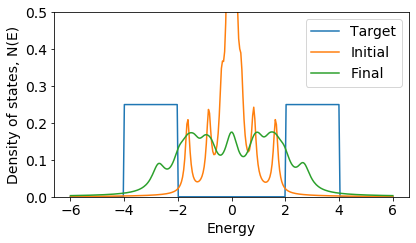

In [148]:
for test in tests:
    plt.plot(test.eex, test.principal_target, label = "Target")
    plt.plot(test.eex, test.init_config.get_DOS(), label = "Initial")
    plt.plot(test.eex, configuration(test.occupied_sites, setup = test.setup).get_DOS(gam = 0.3), label = "Final")
    plt.legend()
    plt.xlabel("Energy")
    plt.ylabel("Density of states, N(E)")
    plt.ylim([0,0.5])
    plt.show()

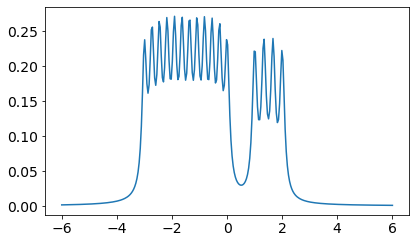

In [149]:
for test in tests:
    plt.plot(test.eex, test.target, label = "Target")

In [ ]:
# Issues
# 1) Need a way to consistently pick N atoms in target function
# 2) Add a way to add iterations to an optimizaation run